In [1]:
import copy
import hydra
import torch
from hydra import compose, initialize
from core.manipulation_set import FrequencyManipulationSet, RGBManipulationSet
import torchvision
from utils import feature_visualisation
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with initialize(version_base=None, config_path="../config"):
    cfg = compose(
        config_name="config_many_images",
        overrides=["model.target_neuron=128"],
    )

In [3]:
device = "cuda:1"
original_weights = cfg.model.get("original_weights_path", None)
if original_weights:
    original_weights = "{}/{}".format(cfg.model_dir, original_weights)
data_dir = cfg.data_dir
output_dir = cfg.output_dir
dataset = cfg.data
default_layer_str = cfg.model.layer
n_out = cfg.model.n_out
image_dims = cfg.data.image_dims
n_channels = cfg.data.n_channels
class_dict_file = cfg.data.get("class_dict_file", None)

fv_sd = float(cfg.fv_sd)
fv_dist = cfg.fv_dist
fv_domain = cfg.fv_domain
target_img_paths = [
    # "../assets/image_dep_gandola/inet_val_ILSVRC2012_val_00023907.JPEG",
    "../assets/image_dep_gandola/inet_train_n03496892_19229.JPEG",
    # "../assets/image_dep_gandola/sketch_sketch_30.JPEG",
    # "../assets/image_dep_gandola/inet_train_n02860847_23542.JPEG",
    # "../assets/image_dep_gandola/inet_val_ILSVRC2012_val_00008714.JPEG",
    # "../assets/image_dep_gandola/inet_val_ILSVRC2012_val_00043010.JPEG",
]  # cfg.target_img_path
batch_size = cfg.batch_size
train_original = cfg.train_original
replace_relu = cfg.replace_relu
alpha = cfg.alpha
w = cfg.w
img_str = cfg.img_str
gamma = cfg.gamma
lr = cfg.lr
man_batch_size = cfg.man_batch_size
zero_rate = cfg.get("zero_rate", 0.5)
tunnel = cfg.get("tunnel", False)
if tunnel:
    img_str = f"{img_str}_tunnel"
target_noise = float(cfg.get("target_noise", 0.0))

In [4]:
normalize = hydra.utils.instantiate(cfg.data.normalize)
denormalize = hydra.utils.instantiate(cfg.data.denormalize)
resize_transforms = hydra.utils.instantiate(cfg.data.resize_transforms)
image_transforms = hydra.utils.instantiate(dataset.fv_transforms)
image_transforms = torchvision.transforms.Compose(image_transforms)

In [5]:
model = hydra.utils.instantiate(cfg.model.model)
if original_weights is not None:
    model.load_state_dict(torch.load(original_weights, map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
target_neuron = int(cfg.model.target_neuron)

In [7]:
target_img_path = target_img_paths[0]

In [8]:
noise_ds_type = FrequencyManipulationSet if fv_domain == "freq" else RGBManipulationSet
noise_dataset = noise_ds_type(
    image_dims,
    target_img_path,
    normalize,
    denormalize,
    image_transforms,
    resize_transforms,
    n_channels,
    fv_sd,
    fv_dist,
    zero_rate,
    tunnel,
    target_noise,
    device,
)

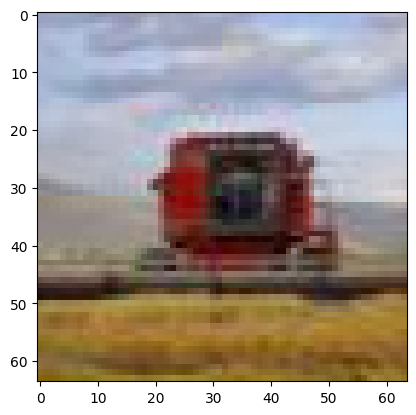

In [9]:
tstart = copy.deepcopy(noise_dataset.param)  # + noise_dataset.get_init_value())
f = noise_dataset.forward
plt.imshow(noise_dataset.to_image(tstart)[0].permute(1, 2, 0).detach().cpu().numpy())

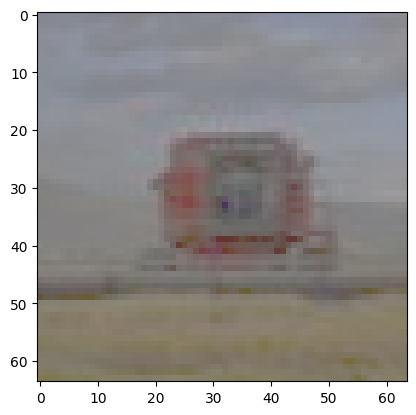

In [10]:
tstart = copy.deepcopy(noise_dataset.param) / 4  # + noise_dataset.get_init_value())
f = noise_dataset.forward
img = noise_dataset.to_image(tstart)[0]
plt.imshow(img.permute(1, 2, 0).detach().cpu())
torchvision.utils.save_image(img, target_img_path.replace(".JPEG", "_div_by_4.jpg"))

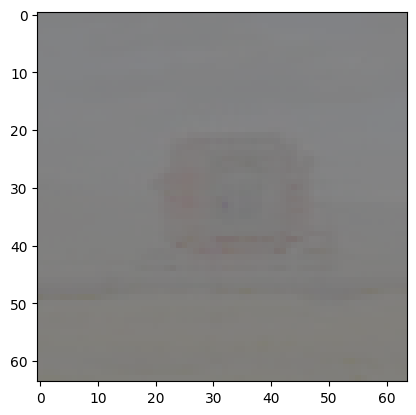

In [11]:
tstart = copy.deepcopy(noise_dataset.param)
tstart /= tstart.norm(p=2)
f = noise_dataset.forward
img = noise_dataset.to_image(tstart)[0]
plt.imshow(img.permute(1, 2, 0).detach().cpu())
torchvision.utils.save_image(img, target_img_path.replace(".JPEG", "_norm.jpg"))

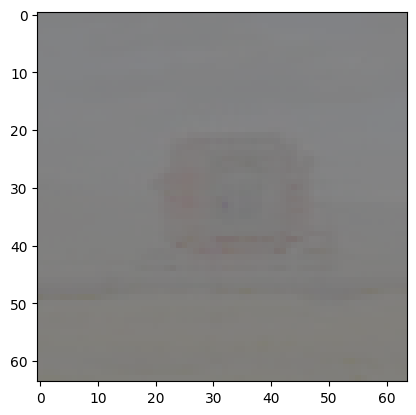

In [12]:
tstart = copy.deepcopy(noise_dataset.param)
tstart /= tstart.norm(p=2)
f = noise_dataset.forward
img = noise_dataset.to_image(tstart)[0]
plt.imshow(img.permute(1, 2, 0).detach().cpu())
torchvision.utils.save_image(img, target_img_path.replace(".JPEG", "_norm.jpg"))

## For each image we perform feature visualisation until convergence (small grad norm)

In [13]:
original = copy.deepcopy(noise_dataset.param)
tstart = copy.deepcopy(noise_dataset.param)
tstart = tstart.to(device).requires_grad_()

optimizer_fv = torch.optim.AdamW([tstart], lr=0.01)
torch.set_printoptions(precision=8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fv, step_size=200, gamma=0.5)
loss = 10000
n = 0
while 1:
    optimizer_fv.zero_grad()

    y_t = model(f(tstart))[0]
    grd = torch.autograd.grad(y_t[target_neuron], tstart, create_graph=True)
    loss = -y_t[target_neuron]
    grd_state = grd[0].pow(2).mean()

    if grd_state < 1e-4:
        break
    if n % 100 == 0:
        print(loss)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_([tstart], 1.0)
    optimizer_fv.step()
    if n < 2000:
        scheduler.step()
    n += 1

print(grd[0].abs().pow(2).mean())
print(grd[0].abs().max().pow(2))

tensor(4.32738018, device='cuda:1', grad_fn=<NegBackward0>)
tensor(8.79120198e-05, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.02585153, device='cuda:1', grad_fn=<PowBackward0>)


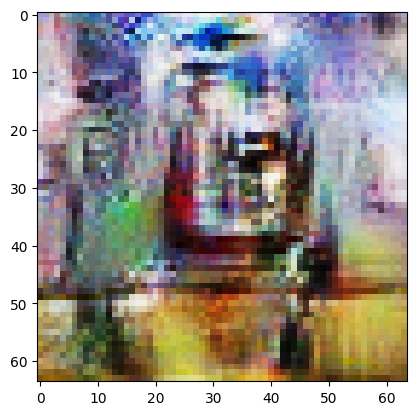

In [14]:
fwrd = copy.deepcopy(noise_dataset.to_image(tstart).detach().cpu())
plt.imshow(fwrd[0].permute(1, 2, 0).numpy())

In [15]:
torchvision.utils.save_image(fwrd, target_img_path.replace(".JPEG", "_max_act.jpg"))

# save zeros like fwrd
fwrd2 = (
    noise_dataset.to_image(torch.zeros_like(tstart)).detach().cpu()
)
plt.imshow(fwrd2[0].permute(1, 2, 0).numpy())
torchvision.utils.save_image(fwrd2, "../assets/image_dep/zeros.JPEG")

# random rgb color
pink_color = torch.tensor([255, 192, 203], dtype=torch.uint8).view(3, 1, 1)/255

# Create a 3-channel image of size 224x224 filled with pink
pink_tensor = pink_color.expand(3, 224, 224).float()
plt.imshow(pink_tensor.permute(1, 2, 0).numpy())
torchvision.utils.save_image(pink_tensor.float(), "../assets/image_dep/pink.JPEG")


img, _, tstart = feature_visualisation(
    net=model,
    noise_dataset=noise_dataset,
    man_index=target_neuron,
    lr=0.01,
    n_steps=200,
    init_mean=torch.tensor([]),
    save_list=[],
    tf=image_transforms,
    adam=True,
    grad_clip=True,
    layer_str=default_layer_str,
    device=device,
)
plt.imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())
torchvision.utils.save_image(img[0], "../assets/image_dep/max_act.JPEG")

def generate_radial_gradient_with_colors(image_size=224):
    # Generate a grid of coordinates (X, Y)
    y, x = torch.meshgrid(torch.arange(image_size), torch.arange(image_size))

    # Center of the image
    center = torch.tensor([image_size // 2, image_size // 2])

    # Calculate the distance from each pixel to the center
    distance = torch.sqrt((x - center[1])**2 + (y - center[0])**2)

    # Normalize the distance to range from 0 to 1
    max_distance = torch.max(distance)
    normalized_distance = distance / max_distance

    # Create fun colors using sine waves for R, G, and B
    r = torch.sin(2 * np.pi * normalized_distance + 0)  # Red channel (sine wave)
    g = torch.sin(2 * np.pi * normalized_distance + np.pi/2)  # Green channel (phase shift)
    b = torch.sin(2 * np.pi * normalized_distance + np.pi)  # Blue channel (another phase shift)

    # Stack them into a single image tensor (3, H, W)
    color_image = torch.stack([r, g, b], dim=0)

    # Normalize colors to be in the range [0, 1]
    color_image = (color_image - color_image.min()) / (color_image.max() - color_image.min())

    return color_image

# Generate a colorful radial gradient image
gradient_img = generate_radial_gradient_with_colors(image_size=224)

# To visualize the result using matplotlib
plt.imshow(gradient_img.permute(1, 2, 0).numpy())  # Convert from (C, H, W) to (H, W, C)
plt.axis('off')
plt.show()
torchvision.utils.save_image(gradient_img, "../assets/image_dep/rotated_gradient.JPEG")